<a href="https://colab.research.google.com/github/awoodbur/authentication/blob/main/Video_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytube
!pip install av

     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 37.2MB 81kB/s 


In [ ]:
!git clone https://github.com/gtoderici/sports-1m-dataset.git

Cloning into 'sports-1m-dataset'...
remote: Enumerating objects: 57, done.
remote: Total 57 (delta 0), reused 0 (delta 0), pack-reused 57
Unpacking objects: 100% (57/57), done.
Checking out files: 100% (27/27), done.


In [ ]:
import torch
from pytube import YouTube 
import av
import torchvision
import matplotlib.pyplot as plt
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from tqdm import tqdm
import os
import gc
from google.colab import drive
import glob
from keras.preprocessing import image

In [ ]:
data = []
t_data = [] = []
with open('/content/sports-1m-dataset/original/test_partition.txt') as test_file:
  data = test_file.read().split('\n')
with open('/content/sports-1m-dataset/original/train_partition.txt') as train_file:
  t_data = train_file.read().split('\n')


full_data = [x.split(' ') for x in data]
full_data.pop()
urls = [x[0] for x in full_data]
labels = [x[1].split(',')[0] for x in full_data]

full_t_data = [x.split(' ') for x in t_data]
full_t_data.pop()
t_urls = [x[0] for x in full_t_data]
t_labels = [x[1].split(',')[0] for x in full_t_data]

In [ ]:
SAVE_PATH = "/content" #to_do 
link="https://www.youtube.com/watch?v=UDqivjS-lpI"
yt = YouTube(link)
stream = yt.streams.first()
stream.download(SAVE_PATH)

'/content/Central Missouri HeptathlonDecathlon Highlight.mp4'

In [ ]:
video = torchvision.io.read_video('Central Missouri HeptathlonDecathlon Highlight.mp4')

/usr/local/lib/python3.7/dist-packages/torchvision/io/video.py:159: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  "The pts_unit 'pts' gives wrong results and will be removed in a "


torch.Size([5625, 360, 480, 3])


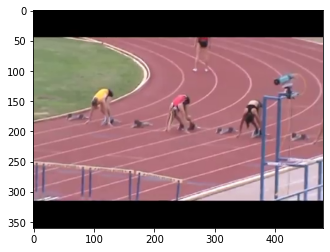

In [ ]:
print(video[0].size())

plt.imshow(video[0].numpy()[1024])

In [ ]:
class VideoDataset(Dataset):
  def __init__(self, data, labels, grayscale=True):
    self.data = data
    self.labels = labels
    self.grayscale = grayscale

  def __getitem__(self, i):
    yt = YouTube(self.data[i])
    stream = yt.streams.first()
    if not os.path.isfile('/content/' + yt.title+'.mp4'):
      stream.download(SAVE_PATH)
    video = torchvision.io.read_video(yt.title+'.mp4')[0]
    frames = video.size()[0]
    # midframe = frames / 2
    video = video[frames // 2]
    if self.grayscale:
      video = torch.FloatTensor(self.rgb2gray(video.numpy()))
    return torch.unsqueeze(video, 0), self.labels[i]

  def __len__(self):
    return len(self.data)

  def rgb2gray(self, rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

my_dataset = VideoDataset(t_urls, t_labels)
# for x in my_dataset.data:
#   print(f"data: {x}")
print(len(t_data))
print(len(my_dataset.data))
test_video, test_label = my_dataset[49]
print(test_video.size())

914492
914491


/usr/local/lib/python3.7/dist-packages/torchvision/io/video.py:159: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  "The pts_unit 'pts' gives wrong results and will be removed in a "


torch.Size([1, 360, 480])


In [ ]:
class VideoRecognizer(torch.nn.Module):
  def __init__(self, dataset):
    self.__dict__.update(locals())
    super(VideoRecognizer, self).__init__()
    # self.weight = torch.Tensor(self.out_channels, self.n_channels, 
    #                            *kernel_size)
    self.bias = Parameter(torch.Tensor(out_channels))

  def forward(self, x):
    return F.conv2d(x, self.weight, 
                    self.bias, self.stride, 
                    self.padding, self.dilation, 
                    self.groups)
    
  def __call__(self, x):
    return self.forward(x)

class ConvNetwork(torch.nn.Module):
  def __init__(self, dataset):
    super(ConvNetwork, self).__init__()
    x, y = dataset[0]
    batch, h, w = x.size()
    output = 10
    self.conv1 = nn.Conv2d(1, 10, (3, 3), padding=(1, 1)),
    self.relu1 = nn.ReLU(),
    self.maxpool1 = nn.MaxPool2d((2, 2), stride=2),
    self.conv2 = nn.Conv2d(10, output, (28,28), padding=(0,0)),
    self.relu2 = nn.ReLU(),
    self.maxpool2 = nn.MaxPool2d((2, 2), stride=2),
    self.flatten = nn.Flatten(1, 1),
    self.linear = nn.Linear(106, 10), 
    self.softmax = nn.Softmax()

    # self.net = nn.Sequential(
    #     nn.Conv2d(1, 10, (3, 3), padding=(1, 1)),
    #     nn.ReLU(),
    #     nn.MaxPool2d((2, 2), stride=2),
    #     nn.Conv2d(10, output, (28,28), padding=(0,0)),
    #     nn.ReLU(),
    #     nn.MaxPool2d((2, 2), stride=2),
    #     nn.Flatten(1, 1),
    #     nn.Linear(106, 10), 
    #     nn.Softmax()
    # )

  def forward(self, x):
    print(f"Conv1 type: {type(self.conv1[0])}")
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = self.relu1(x)
    x = self.conv2(x)
    x = self.maxpool2(x)
    x = self.relu2(x)
    x = self.flatten(x)
    x = self.linear(x)
    x = self.softmax(x)
    # return self.net(x).squeeze(2).squeeze(2)

  def __call__(self, x):
    return self.forward(x)

def rgb2gray(rgb):
  return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

torch.Size([10, 360, 480, 3])
torch.Size([10, 360, 480])


/usr/local/lib/python3.7/dist-packages/torchvision/io/video.py:159: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  "The pts_unit 'pts' gives wrong results and will be removed in a "


ConvNetwork(
  (softmax): Softmax(dim=None)
)
Conv1 type: <class 'torch.nn.modules.conv.Conv2d'>


TypeError: ignored

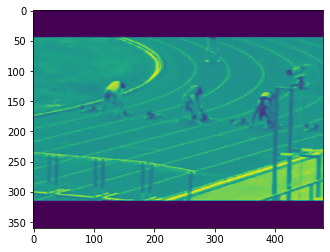

In [ ]:
tensor = video[0][1000:1010]
new_tensor = video[0][1000:1010]

print(tensor.size())

plt.imshow(tensor[0])

tensor = torch.FloatTensor(rgb2gray(tensor.numpy()))

# for i in range(tensor.size()[0]):
#   print(tensor[i].size())
  # gray_list.append(torch.FloatTensor(rgb2gray(tensor[i].numpy())))
# tensor = torchvision.transforms.ToTensor()(torchvision.transforms.ToPILImage()(tensor.permute(2, 0, 1)).convert('LA'))

print(tensor.size())

plt.imshow(tensor[0])

# ds = VideoDataset([tensor], [1])
model = ConvNetwork(my_dataset)
print(model)
tensor = torch.unsqueeze(tensor, 2).permute(0, 2, 1, 3)
result = model(tensor)

print(result.size())



In [ ]:
vgg_model = torchvision.models.vgg16(pretrained=True)

res2 = vgg_model(new_tensor.permute(0,3,1,2).type(torch.FloatTensor))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
class CustomVGG(nn.Module):
    def __init__(self, num_classes=487, start_frozen=False):
        super(CustomVGG, self).__init__()

        self.final_layer = nn.Linear(1000,487)
        self.model = torchvision.models.vgg16(pretrained=True)

    
    def forward(self, x):
      x1 = self.model(x) 
      out = self.final_layer(x1)
      return out
        

In [ ]:
class SimpleConvNetwork(nn.Module):
  def __init__(self):
    super(SimpleConvNetwork, self).__init__()
    self.conv1 = nn.Conv2d(3, 10, (3, 3), padding=(1, 1)).cuda(),
    self.relu1 = nn.ReLU().cuda(),
    self.maxpool1 = nn.MaxPool2d((2, 2), stride=2).cuda(),
    self.conv2 = nn.Conv2d(10, 10, (28,28), padding=(0,0)).cuda(),
    self.relu2 = nn.ReLU().cuda(),
    self.maxpool2 = nn.MaxPool2d((2, 2), stride=2).cuda(),
    self.flatten = nn.Flatten(1, 1).cuda(),
    self.linear = nn.Linear(106, 10).cuda(), 
    self.softmax = nn.Softmax().cuda()

  def forward(self, x):
    x = self.conv1[0](x)
    x = self.relu1[0](x)
    x = self.maxpool1[0](x)
    x = self.conv2[0](x)
    x = self.relu2[0](x)
    x = self.maxpool2[0](x)
    x = self.flatten[0](x)
    print(x.size())
    x = self.linear[0](x)
    return self.softmax[0](x)
    

In [ ]:

videoFile = ''
cap = cv2.VideoCapture(videoFile.split(' ')[0].split('/')[1])   # capturing the video from the given path
frameRate = cap.get(5) #frame rate
x=1
# removing all other files from the temp folder
files = glob('temp/*')
for f in files:
    os.remove(f)
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        # storing the frames of this particular video in temp folder
        filename ='temp/' + "_frame%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
 # reading all the frames from temp folder
images = glob.glob("/content/gdrive/MyDrive/vid_frames/*.jpg")

simple_model = SimpleConvNetwork()
simple_model.cuda()

prediction_images = []
for i in range(len(images)):
    img = image.load_img(images[i], target_size=(224,224,3))
    img = image.img_to_array(img)
    img = img/255
    prediction_images.append(img)
    
# converting all the frames for a test video into numpy array
prediction_images = np.array(prediction_images)
# extracting features using pre-trained model
# prediction_images = base_model.predict(prediction_images)

predictions = []
for im in prediction_images:
  im = torch.FloatTensor(im).cuda()
  predictions.append(simple_model(im.permute(2, 0, 1).unsqueeze(0)))

print(f"Prediction length: {len(predictions)}")
print(f"Prediction[0]: {predictions[0]}")

# converting features in one dimensional array
prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*512)
# predicting tags for each array
prediction = vgg_model.predict_classes(prediction_images)
# appending the mode of predictions in predict list to assign the tag to the video
predict.append(y.columns.values[s.mode(prediction)[0][0]])
# appending the actual tag of the video
actual.append(videoFile.split('/')[1].split('_')[1])

torch.Size([1, 10, 42, 42])


RuntimeError: ignored

In [ ]:
print(new_tensor.size())
print(res2.size())

torch.Size([10, 360, 480, 3])
torch.Size([10, 1000])


In [ ]:
optimizer = torch.optim.Adam(vgg_model.parameters())
# loss_function = nn.CrossEntropyLoss()
loss_function = nn.MSELoss()
vgg_dataset = VideoDataset(t_urls, t_labels, grayscale=False)
train_dataloader = torch.utils.data.DataLoader(vgg_dataset)
partial_train_dataloader = train_dataloader

In [ ]:
print(vgg_model.children)
new_model = torchvision.models.vgg16()
new_model.cuda()

<bound method Module.children of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
num_epochs = 1
num_imgs = 10

max_ims = 10

def scope():
  try: 
    for epoch in tqdm(range(num_epochs)):
      gc.collect()
      curr_ims = 0
      for x, y in train_dataloader:
        curr_ims += 1
        if curr_ims >= max_ims:
          continue

        gc.collect()
        optimizer.zero_grad()

        print(x.size())
        x = torch.squeeze(x,1)
        print(x.size())
        prediction = vgg_model(x.permute(0,3,1,2).type(torch.FloatTensor))

        # print(prediction.size())
        # prediction = torch.matmul(torch.ones(10), prediction)
        # print(prediction.size())

        print(prediction.size())

        real_pred = torch.max(prediction.squeeze())
        print(type(real_pred))

        tensor_target = torch.FloatTensor(np.array([int(y[0])]))

        for i, dim in enumerate(real_pred.size()):
          if tensor_target.size()[i] != dim:
            print(f"Sizes didn't match; got sizes {real_pred.size()} and {tensor_target.size()}")



        loss = loss_function(real_pred, tensor_target)

        loss.backward()
        optimizer.step()
        print("Did step function")
  except KeyboardInterrupt:
    pass

scope()

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/io/video.py:159: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  "The pts_unit 'pts' gives wrong results and will be removed in a "


torch.Size([1, 1, 360, 480, 3])
torch.Size([1, 360, 480, 3])
torch.Size([1, 1000])
<class 'torch.Tensor'>


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Did step function


In [ ]:
plt.imshow(tensor[0].squeeze())
# plt.imshow(result[0].squeeze())